<a href="https://colab.research.google.com/github/IbanezUc/proyectoML/blob/main/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importar librerías.

In [284]:
!pip install Prophet

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

from datetime import datetime
from sklearn.model_selection import train_test_split

### Cargar datos del clima.

In [286]:
# Se crea una variable que almacena la ruta de descarga de los datos a usar,
url = 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='

# Se leen los datos del archivo, separados por punto y coma(;) y se almacenan las columas de fecha y hora en una misma columna para facilitar su manipulación.
      # datos_clima = pd.read_csv(url, delimiter = ';', parse_dates = [['FECHA (YYMMDD)','HORA (HHMM)']])

# Hay que configurar el tipo de fecha en el dataset debido a que el formato que adquiere al ser leído genera que el mes del csv
# sea leído como un año.
dateparse = lambda x: datetime.strptime(x, '%y%m%d')

#Se lee el archivo csv desde la ruta de internet, se le indican ciertas modificaciones para su lectura adecuada.
datos_clima = pd.read_csv(url, delimiter = ';', decimal = ',' , parse_dates = ['FECHA (YYMMDD)'], date_parser = dateparse)
#datos_clima = pd.read_csv(url, delimiter = ';')

#Comprobando la información.
datos_clima.head(20)

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Unnamed: 5
0,2012-07-07,100,NaN,NaN,NaN,NaN
1,2012-07-07,200,NaN,NaN,NaN,NaN
2,2012-07-07,300,NaN,NaN,NaN,NaN
3,2012-07-07,400,NaN,NaN,NaN,NaN
4,2012-07-07,500,NaN,NaN,NaN,NaN
5,2012-07-07,600,NaN,NaN,NaN,NaN
6,2012-07-07,700,NaN,NaN,NaN,NaN
7,2012-07-07,800,NaN,NaN,NaN,NaN
8,2012-07-07,900,NaN,NaN,NaN,NaN
9,2012-07-07,1000,NaN,NaN,NaN,NaN


In [287]:
# Se elimina la última columna debido a que no posee datos y, considerando la cantidad de valores no definidos,
# se decidió trabajar con medias diarias, por ende, la columna de horas no será una columna necesaria para el 
# trabajo a realizar.

datos_clima = datos_clima.drop(columns=['HORA (HHMM)', 'Unnamed: 5'])

type(datos_clima['Registros validados'])


pandas.core.series.Series

##### Se divide el dataframe original en pequeños dataframe's en los que cada uno tendrá datos según la columna que se seleccione de registros, sólo para favorecer la comprensión de la información.

In [288]:
data = {'Fecha': datos_clima['FECHA (YYMMDD)'],'datos': datos_clima['Registros validados'] }
datos_preliminares = {'Fecha': datos_clima['FECHA (YYMMDD)'],'datos': datos_clima['Registros preliminares'] }
datos_no_validados = {'Fecha': datos_clima['FECHA (YYMMDD)'],'datos': datos_clima['Registros no validados'] }

type(data)

dict

##### Al separar la información a través del uso de diccionarios, los datos se deberán transformar de vuelta a dataframe.

In [289]:
data = pd.DataFrame(data)
datos_preliminares = pd.DataFrame(datos_preliminares)
datos_no_validados = pd.DataFrame(datos_no_validados)

print(f'Largo df validados: {len(data)}, largo df preliminares: {len(datos_preliminares)}, Largo df no validados: {len(datos_no_validados)}')

Largo df validados: 82415, largo df preliminares: 82415, Largo df no validados: 82415


##### En las siguientes tres celdas se revisarán algunos datos de los 'sub dataframes'

In [290]:
data.head(10)

,Fecha,datos
0,2012-07-07,NaN
1,2012-07-07,NaN
2,2012-07-07,NaN
3,2012-07-07,NaN
4,2012-07-07,NaN
5,2012-07-07,NaN
6,2012-07-07,NaN
7,2012-07-07,NaN
8,2012-07-07,NaN
9,2012-07-07,NaN


In [291]:
datos_preliminares.head(10)

,Fecha,datos
0,2012-07-07,NaN
1,2012-07-07,NaN
2,2012-07-07,NaN
3,2012-07-07,NaN
4,2012-07-07,NaN
5,2012-07-07,NaN
6,2012-07-07,NaN
7,2012-07-07,NaN
8,2012-07-07,NaN
9,2012-07-07,NaN


In [292]:
datos_no_validados.head(10)

,Fecha,datos
0,2012-07-07,NaN
1,2012-07-07,NaN
2,2012-07-07,NaN
3,2012-07-07,NaN
4,2012-07-07,NaN
5,2012-07-07,NaN
6,2012-07-07,NaN
7,2012-07-07,NaN
8,2012-07-07,NaN
9,2012-07-07,NaN


##### Al tener cada uno de ellos muchas filas sin información que aportar en cuanto al material particulado, cada una de ellas serán quitadas de los df, de momento.

In [293]:
# data = data.dropna(axis = 0)
# datos_preliminares = datos_preliminares.dropna(axis = 0)
# datos_no_validados = datos_no_validados.dropna(axis = 0)

# data = data.fillna(0)
# datos_preliminares = datos_preliminares.fillna(0)
# datos_no_validados = datos_no_validados.fillna(0)

print(f'Largo df validados: {len(data)}, largo df preliminares: {len(datos_preliminares)}, Largo df no validados: {len(datos_no_validados)}')

Largo df validados: 82415, largo df preliminares: 82415, Largo df no validados: 82415


Al haber eliminado la columnas de horas, se tienen muchas información que indican la misma fecha de evaluación. Por lo tanto todo valor que se tenga por fecha será agrupado en una sola fila. El indice de material particulado será sumado en la fila que represente la fecha correspondiente.

In [294]:
data = data.groupby('Fecha').agg({'datos': "mean"})
datos_preliminares = datos_preliminares.groupby('Fecha').agg({'datos': "mean"})
datos_no_validados = datos_no_validados.groupby('Fecha').agg({'datos': "mean"})

In [295]:
data.columns

Index(['datos'], dtype='object')

In [296]:
print(f'Largo datos validados: {len(data)}, Largo datos preliminares: {len(datos_preliminares)}')

Largo datos validados: 3434, Largo datos preliminares: 3434


#### Se unen los dataframes de datos validados, preliminares y no validados usando el método cobine_first que, según la documnentación del Python, se unen dataframes y se mantienen los valores del dataframe de la izquierda. En caso de que alguna celda del dataframe de la izquierda tenga un valor 'nan' y el dataframe de la derecha si tenga valor en ella, el dataframe resultante tomará el valor del dataframe de la derecha.

#### Se le da prioridad al dataframe de datos validados, luego a los datos preliminares y finalmente a los no validados en situaciones en que en una fila exista valores validos en más de un dataframe.

In [297]:
df_resultante = data.combine_first(datos_preliminares).combine_first(datos_no_validados)
print(f'total: {len(data)}, Resultado real: {len(df_resultante)}')

df_resultante['datos'].hasnans

total: 3434, Resultado real: 3434


True

#### Se sacarán promedios diarios y mensuales.

#### En el caso de los promedios mensuales su uso será para interpolar datos dentro de un mismo mes para las filas faltantes.

In [298]:
import math

#Sumatoria de emisiones al mes.
suma_emisiones_en_mes = {}

# Se cuentan la cantidad de días que se obtuvieron emisiones. Su función es contar
#.días para que al final de cada mes se saque el promedio.
cant_dias_x_mes = {}

# Promedio de emisiones por mes.
promedios = {}

In [299]:
def obtenerPromedios(dataFrame_a_usar):
# Para cada elemento en el largo del dataset
  for elemento in range(len(dataFrame_a_usar)):

#   fecha = df_resultante.index[elemento]
#   print(fecha)

#   Para sacar el promedio mensual se hará una simulación de que cada día del mes
#   es el mismo día para poder sacar el promedio más fácil.
    fecha = dataFrame_a_usar.index[elemento].to_pydatetime().replace(day=1)

#   Esta variable obtiene el dato de la fila elemento en la columna del dataframe
#   llamada 'datos'. En otras palabras, en cada iteración se obtiene la cantidad 
#   de emisiones en Curicó, por consiguiente, cada uno de los datos que se asignan
#   corresponde a una fecha diferente.
    dato = dataFrame_a_usar.iloc[elemento]['datos']

#   Confirmación de si el dato obtenido de emisiones es nan. En caso de ser 'True',
#   el for se dirige automáticamente a la siguiente iteración ignorando el dato 
#   nan, debido a que no aporta información para la obtención de promedios.
    if math.isnan(dato):
      continue
  
#   ---------------- Se comienzan a hacer cálculos --------------------

#   Considerando que se reemplazaron los días de cada mes por el día 1, se hace 
#   lo siguiente:
#   Si la fecha no está dentro de el diccionario...
    if fecha not in suma_emisiones_en_mes:
#     Crea una instancia de la fecha y le agrega el dato asociado.
      suma_emisiones_en_mes[fecha] = dato
#     indico que el mes tiene su primer día con emisiones encontrado.
      cant_dias_x_mes[fecha] = 1.0
  
#     En caso contrario, Si el mes ya tiene uno o más días con emisiones, hace lo
#     siguiente:
    else:
#     Al diccionario que obtiene la cantidad de emisiones mensuales agrega la 
#     nueva emisión, teniendo en cuenta que cada día del mes se idetnificó como
#     el día 1 del mes correspondiente.
      suma_emisiones_en_mes[fecha] += dato
    
#     Se señala que el mes tuvo un nuevo día con emisiones.
      cant_dias_x_mes[fecha] += 1.0
      
# Para cada mes se calcula la cantidad promedio de emisiones. Notar que el uso de
# el if math.isnan anteriormente, provocará que si hay un mes sin datos de emisiones
# será ignorado ya que no se hizo un cálculo al respecto de ningún día sin datos.
  for meses_emisiones in suma_emisiones_en_mes.keys():
#   Para calcular la suma se divide la sumatoria de emisiones
    promedios[meses_emisiones] = suma_emisiones_en_mes[meses_emisiones]/cant_dias_x_mes[meses_emisiones]

#print(meses_emisiones, cant_dias_x_mes[meses_emisiones])


In [300]:
obtenerPromedios(df_resultante)

#### La siguiente celda corresponde al rellenado de valores nans, los cuales serán rellenados con el promedio mensual hecho con los valores existentes.

###### Esta celda se ha comentado para brindar la funcionalidad de rellenar valores nan luego de hacer un filtro de filas. Se decidió dejar como comentario debido a que fue un aporte para hacerme notar que valores persistían siendo nan luego de modificar la información

In [301]:
'''
# Para cada valor / elememnto a lo largo de la fila.
for elemento in range(len(df_resultante)):
  # Se toma el índice y se obtiene una fecha puntual.
  fecha = df_resultante.index[elemento].to_pydatetime()

  # Se obtiene la cantidad de emisión de la fecha elegida en la iteración.
  dato = df_resultante.iloc[elemento]['datos']
  
  # Evalúo si el valor es nan. En caso de ser positivo:
  if math.isnan(dato):
    # Pregunto si el diccionario 'promedios' tiene el mes del valor nan. Esto es
    # Para saber si puede reemplazar el valor nan por un valor existente en el 
    # diccionario.
    if fecha.replace(day=1) in promedios:
      # En el lugar en donde se encuentra el valor nan se asigna, o reemplaza s, 
      # el promedio mensual.
      df_resultante['datos'][elemento] = promedios[fecha.replace(day=1)]
      print(df_resultante['datos'][elemento])
'''

"\n# Para cada valor / elememnto a lo largo de la fila.\nfor elemento in range(len(df_resultante)):\n  # Se toma el índice y se obtiene una fecha puntual.\n  fecha = df_resultante.index[elemento].to_pydatetime()\n\n  # Se obtiene la cantidad de emisión de la fecha elegida en la iteración.\n  dato = df_resultante.iloc[elemento]['datos']\n  \n  # Evalúo si el valor es nan. En caso de ser positivo:\n  if math.isnan(dato):\n    # Pregunto si el diccionario 'promedios' tiene el mes del valor nan. Esto es\n    # Para saber si puede reemplazar el valor nan por un valor existente en el \n    # diccionario.\n    if fecha.replace(day=1) in promedios:\n      # En el lugar en donde se encuentra el valor nan se asigna, o reemplaza s, \n      # el promedio mensual.\n      df_resultante['datos'][elemento] = promedios[fecha.replace(day=1)]\n      print(df_resultante['datos'][elemento])\n"

#### Al visualizar los promedios mensuales, se puede notar que hay seis meses que no tienen información de promedios. Son los meses entre octubre del año 2012 y y Febrero del año 2013, incluyendo esas fechas. 

#### Se considera que el intentar ingresar información manual, o datos dummy, a tal cantidad de tiempo podría perjudicar el funcionamiento del trabajo o, si se desea, la visualización de información fidedigna.

In [302]:
for elemento in promedios.keys():
  print(f'Elemento: {elemento}, promedio: {promedios[elemento]}')

Elemento: 2012-07-01 00:00:00, promedio: 95.73782073888886
Elemento: 2012-08-01 00:00:00, promedio: 179.6865568942866
Elemento: 2012-09-01 00:00:00, promedio: 772.7471768398586
Elemento: 2013-03-01 00:00:00, promedio: 19.87453249181861
Elemento: 2013-04-01 00:00:00, promedio: 30.13609777903256
Elemento: 2013-05-01 00:00:00, promedio: 63.196568246568255
Elemento: 2013-06-01 00:00:00, promedio: 59.05784934969411
Elemento: 2013-07-01 00:00:00, promedio: 54.67516845006326
Elemento: 2013-08-01 00:00:00, promedio: 54.67913000977518
Elemento: 2013-09-01 00:00:00, promedio: 29.37724292615598
Elemento: 2013-10-01 00:00:00, promedio: 15.011608015640276
Elemento: 2013-11-01 00:00:00, promedio: 8.743357487922706
Elemento: 2013-12-01 00:00:00, promedio: 9.331364789955254
Elemento: 2014-01-01 00:00:00, promedio: 11.011590424167007
Elemento: 2014-02-01 00:00:00, promedio: 10.10849567099567
Elemento: 2014-03-01 00:00:00, promedio: 16.810801614623497
Elemento: 2014-04-01 00:00:00, promedio: 36.13703337

#### Una forma gráfica de visualizar la falta de datos es con el gráfico de serie de tiempo.

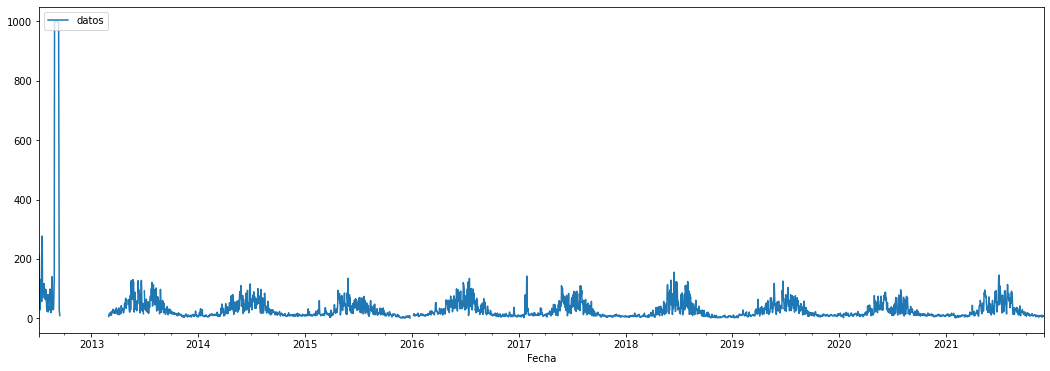

In [303]:
fig, ax = plt.subplots(figsize = (18,6))

df_resultante.plot(y = 'datos', ax = ax)
plt.legend(loc = 'upper left')

#### Por lo tanto se almacenará información entre los meses consecutivos que poseen información. Marzo 2013 en adelante

In [304]:
df_filtrado = df_resultante.loc['2013-03-01  00:00:00':]

df_filtrado.head()

,datos
Fecha,
2013-03-01,5.875000
2013-03-02,10.250000
2013-03-03,15.333333
2013-03-04,17.041667
2013-03-05,17.125000


In [305]:
# Vaciar sumatoria de emisiones al mes.
suma_emisiones_en_mes = {}

# Vaciar la cantidad de días
cant_dias_x_mes = {}

# Vaciar Promedio de emisiones por mes.
promedios = {}

obtenerPromedios(df_filtrado)

In [306]:
for elemento in promedios.keys():
  print(f'Elemento: {elemento}, promedio: {promedios[elemento]}')

Elemento: 2013-03-01 00:00:00, promedio: 19.87453249181861
Elemento: 2013-04-01 00:00:00, promedio: 30.13609777903256
Elemento: 2013-05-01 00:00:00, promedio: 63.196568246568255
Elemento: 2013-06-01 00:00:00, promedio: 59.05784934969411
Elemento: 2013-07-01 00:00:00, promedio: 54.67516845006326
Elemento: 2013-08-01 00:00:00, promedio: 54.67913000977518
Elemento: 2013-09-01 00:00:00, promedio: 29.37724292615598
Elemento: 2013-10-01 00:00:00, promedio: 15.011608015640276
Elemento: 2013-11-01 00:00:00, promedio: 8.743357487922706
Elemento: 2013-12-01 00:00:00, promedio: 9.331364789955254
Elemento: 2014-01-01 00:00:00, promedio: 11.011590424167007
Elemento: 2014-02-01 00:00:00, promedio: 10.10849567099567
Elemento: 2014-03-01 00:00:00, promedio: 16.810801614623497
Elemento: 2014-04-01 00:00:00, promedio: 36.13703337725077
Elemento: 2014-05-01 00:00:00, promedio: 47.16581391161188
Elemento: 2014-06-01 00:00:00, promedio: 50.66573553258336
Elemento: 2014-07-01 00:00:00, promedio: 59.40007012

In [307]:
# Para cada valor / elememnto a lo largo de la fila.
for elemento in range(len(df_filtrado)):
  # Se toma el índice y se obtiene una fecha puntual.
  fecha = df_filtrado.index[elemento].to_pydatetime()

  # Se obtiene la cantidad de emisión de la fecha elegida en la iteración.
  dato = df_filtrado.iloc[elemento]['datos']
  
  # Evalúo si el valor es nan. En caso de ser positivo:
  if math.isnan(dato):
    # Pregunto si el diccionario 'promedios' tiene el mes del valor nan. Esto es
    # Para saber si puede reemplazar el valor nan por un valor existente en el 
    # diccionario.
    if fecha.replace(day=1) in promedios:
      # En el lugar en donde se encuentra el valor nan se asigna, o reemplaza s, 
      # el promedio mensual.
      df_filtrado['datos'][elemento] = promedios[fecha.replace(day=1)]
      print(f'{fecha}: {df_filtrado["datos"][elemento]}')


2013-05-03 00:00:00: 63.196568246568255
2013-05-04 00:00:00: 63.196568246568255
2013-05-05 00:00:00: 63.196568246568255
2013-05-06 00:00:00: 63.196568246568255
2013-06-29 00:00:00: 59.05784934969411
2013-06-30 00:00:00: 59.05784934969411
2015-03-28 00:00:00: 15.270616542750409
2015-12-27 00:00:00: 4.280855255016723
2015-12-28 00:00:00: 4.280855255016723
2015-12-29 00:00:00: 4.280855255016723
2015-12-30 00:00:00: 4.280855255016723
2015-12-31 00:00:00: 4.280855255016723
2016-01-01 00:00:00: 10.962815123188404
2016-01-02 00:00:00: 10.962815123188404
2016-01-03 00:00:00: 10.962815123188404
2016-01-04 00:00:00: 10.962815123188404
2016-01-05 00:00:00: 10.962815123188404
2016-01-06 00:00:00: 10.962815123188404


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Gráfico de serie de tiempo.

                datos
Fecha                
2013-03-01   5.875000
2013-03-02  10.250000
2013-03-03  15.333333
2013-03-04  17.041667
2013-03-05  17.125000


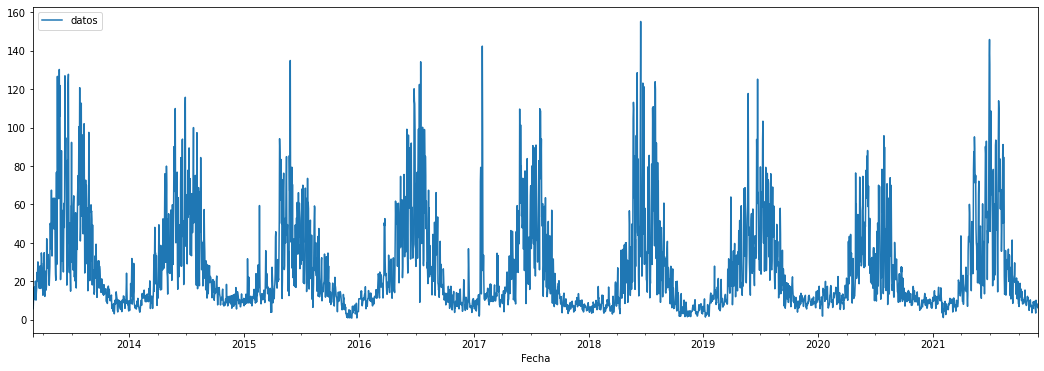

In [308]:
fig, ax = plt.subplots(figsize = (18,6))
print(df_filtrado.head())


df_filtrado.plot(y = 'datos', ax = ax)
plt.legend(loc = 'upper left')


#### Separar el dataset final para prueba y entrenamiento

###### Arbitrariamente se eligió dejar un 20% de la información para el conjunto de prueba. En primera instancia se considera que el tamaño de prueba es lo suficientemebte grande.

In [309]:
'''
print(f'Tamaño dataset: {len(df_filtrado)}')

entrenamiento, prueba = train_test_split(df_filtrado, test_size= 0.2, shuffle= False)

print(f'Tamaños \nEntrenamiento: {len(entrenamiento)}, prueba: {len(prueba)}')
print(f'Suma: {len(entrenamiento)+len(prueba)}')


entrenamiento.tail()
'''

df_train = df_filtrado.loc[:'2019-12-31  00:00:00']
df_test  = df_filtrado.loc['2020-01-01  00:00:00':]

In [310]:
df_train = df_train.reset_index()
df_test  = df_test.reset_index()

In [333]:
df_train.columns = ['ds', 'y']
df_test.columns = ['ds', 'y']
df_train

,ds,y
0,2013-03-01,5.875000
1,2013-03-02,10.250000
2,2013-03-03,15.333333
3,2013-03-04,17.041667
4,2013-03-05,17.125000
...,...,...
2492,2019-12-27,14.791667
2493,2019-12-28,8.958333
2494,2019-12-29,10.583333
2495,2019-12-30,13.458333


#### Comienzo a usar Prophet

###### Se crea el modelo de Prophet y se asegura que este tenga una periodicidad diaria. Luego, se hace el entrenamiento.

In [334]:
modelo = Prophet(daily_seasonality = True)
modelo.fit(df_train)

###### Se hace la predicción con Prophet 

In [335]:
prediccion = modelo.predict(df_test[['ds']])

###### Se toman los valores predichos. 

In [336]:
y_hat_prediccion = prediccion.yhat.values

##### Se decide hacer un cambio en el dataframe final. Se decide mover el índice fecha como columna

In [337]:
df_filtrado = df_filtrado.reset_index()

   index      Fecha      datos
0      0 2013-03-01   5.875000
1      1 2013-03-02  10.250000
2      2 2013-03-03  15.333333
3      3 2013-03-04  17.041667
4      4 2013-03-05  17.125000


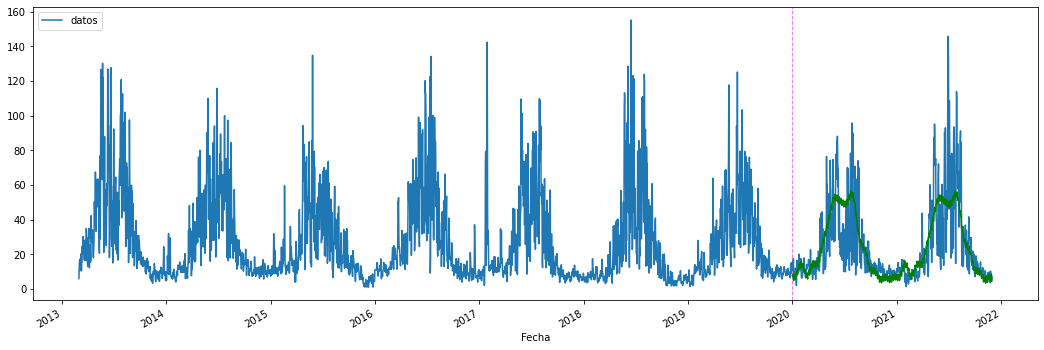

In [339]:
fig, ax = plt.subplots(figsize = (18,6))
print(df_filtrado.head())

# Se brindan las fechas y se le da la línea separadora entre predicción y los datos
# Usados para predecir.
plt.axvline(pd.to_datetime(str(df_test.ds.values[0])), c='violet', ls='--', lw=1)

# Se grafican los datos del dataset global
df_filtrado.plot(x = 'Fecha', y = 'datos', ax = ax)
plt.legend(loc = 'upper left')

# Se agregan los datos predichos.
ax.plot(pd.to_datetime(df_test.ds.values), y_hat_prediccion,
        color="green", label="predicted")

#### La predicción globalmente es correcta. Si bien, hay un error dentro de la primera mitad de ella, se debe a que la calidad del aire tuvo una variación drástica en pocos días aunque luego se 'normalizó' y comenzó a tener el comportamiento esperado por ella.